# This Notebook performs below tasks  

PreRequisite : Execute the OER_clustering_diseases_only.ipynb to get the cluster assignments using KModes and KMeans algorithms.

1.   Evaluate clusters with a Silhouette score greater than 0.8 for both KMeans and Kmodes.
2.   Examine the overlap in populations between KMeans and Kmodes for the clusters identified in point #1

# INSTALL PACKAGES

In [ ]:
!pip install KModes

In [ ]:
!pip install yellowbrick

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 2.3 MB/s eta 0:00:00


# IMPORT PACKAGES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
#from kmodes.kmodes import KModes
from sklearn.metrics.cluster import adjusted_rand_score
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn import metrics
from matplotlib import cm
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
# from yellowbrick.cluster import KElbowVisualizer
# from yellowbrick.cluster import InterclusterDistance
# from yellowbrick.cluster import SilhouetteVisualizer
from matplotlib.colors import ListedColormap
import seaborn as sns
import networkx as nx
import math
pd.set_option('display.max_columns', None)

# USER DEFINED FUNCTIONS

## General Functions

#### Cluster Disease Percentage

In [ ]:
def cluster_disease_percentage(clustering_result, patient_data, n, verbose=False):
  # Get unique cluster labels
  unique_clusters = np.unique(clustering_result)

  # Initialize an empty DataFrame to store disease percentages
  disease_percentage_df = pd.DataFrame(index=patient_data.columns, columns=unique_clusters)

  # Iterate over each cluster
  for cluster_id in unique_clusters:
      # Select patients in the current cluster
      cluster_patients = patient_data.iloc[clustering_result == cluster_id]
      disease_counts = cluster_patients.sum()
      # Calculate disease percentages for the cluster
      disease_percentages = (disease_counts / len(cluster_patients)) * 100
      formatted_percentages = disease_percentages.apply(lambda x: float("{:.2f}".format(x)))
      # Assign percentages to the DataFrame
      disease_percentage_df[cluster_id] = formatted_percentages

      if verbose:
          top_n_diseases = disease_percentages.sort_values(ascending=False).head(n).index

          print("Cluster " + str(cluster_id) + " Top Features")
          print(str(top_n_diseases.values))
          print("Cluster Size: " + str(len(cluster_patients)) + '\n')
  pd.set_option('display.max_columns', None)
  pd.set_option('display.max_rows', None)

  return disease_percentage_df

#### Filter Cluster by demographics

In [ ]:
def filter_cluster_by_demographics(disease_percentage_df, dems):
    filtered_disease_percentage_dfs = {}

    for cluster_id in disease_percentage_df.columns:
        cluster_df = disease_percentage_df[cluster_id]

        # Filter by the specified row indices in dems
        filtered_cluster_df1 = cluster_df[cluster_df.index.isin(dems)]
        filtered_cluster_df = filtered_cluster_df1.sort_values(ascending=False)

        # getting the index data
        index = filtered_cluster_df.index
        # removing duplicate indices separately
        filtered_cluster_df = filtered_cluster_df[~index.duplicated(keep="first")]
        filtered_disease_percentage_dfs[cluster_id] = filtered_cluster_df

    return filtered_disease_percentage_dfs

def plot_cluster_demographics_separately(filtered_data, variable_subsets, subset_titles):

    for cluster_id, cluster_df in filtered_data.items():

        num_subplots = len(variable_subsets)
        num_rows = (num_subplots + 1) // 2  # Calculate the number of rows needed

        fig, axes = plt.subplots(num_rows, 2, figsize=(12, 5 * num_rows))
        #fig.suptitle(f'Cluster {cluster_names}', fontsize=16)

        if num_rows == 1:
            axes = [axes]  # Convert to list if only one row

        for i, ax_row in enumerate(axes):
            for j, vars in enumerate(variable_subsets[i * 2:i * 2 + 2]):
                subset_df = cluster_df[cluster_df.index.isin(vars)]
                rounded_values = subset_df.round().astype(int)
                bars = ax_row[j].bar(rounded_values.index, rounded_values, width=0.7)
                ax_row[j].set_title(subset_titles[i * 2 + j])
                ax_row[j].set_xlabel('Demographics')
                ax_row[j].set_ylabel('Percentage')
                ax_row[j].tick_params(axis='x', rotation=85)
                ax_row[j].set_ylim(0, 100)  # Set the y-axis limit to 0-100

                # Annotate bars with exact percentages
                for bar in bars:
                    height = bar.get_height()
                    ax_row[j].text(
                        bar.get_x() + bar.get_width() / 2,
                        height,
                        f'{height}%',
                        ha='center',
                        va='bottom'
                    )

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

### Filter dataset by cluster

In [ ]:
def filter_dataset_by_clusters(data, kmodes_clusters=[], kmeans_clusters=[]):

  kmodes_mask = data['KModes_Cluster'].isin(kmodes_clusters) if kmodes_clusters else pd.Series([True] * len(data))
  kmeans_mask = data['KMeans_Cluster'].isin(kmeans_clusters) if kmeans_clusters else pd.Series([True] * len(data))

  # Combine masks using logical OR to filter data
  result_df = data[kmodes_mask | kmeans_mask]
  intersection_df = data[kmodes_mask & kmeans_mask]

  return result_df,intersection_df

## OER Calculation

#### Calculate Disease Prevalence

In [ ]:
def calculate_disease_prevalence(df, clustering_labels):
  cluster_prevalence = {}
  unique_clusters = np.unique(clustering_labels)

  for cluster in unique_clusters:
    # print(cluster)
    # Subset the DataFrame for the current cluster
    # if cluster == 7:
    cluster_df = df[clustering_labels == cluster]

    # Calculate the prevalence (sum) of each disease in the cluster
    prevalence = cluster_df.sum()
    # Store the prevalence in the dictionary
    cluster_prevalence[cluster] = prevalence

      # # Convert the dictionary to a DataFrame
      # prevalence_df = pd.DataFrame(cluster_prevalence)
  return cluster_prevalence

#### Calculate Population Disease Prevalence

In [ ]:
def calculate_population_disease_prevalence(df, pop_size):
    # Calculates population-wise percentage disease prevalence
    prevalence = df.sum()
    return prevalence/pop_size

#### Calculate Population Expected Coexistence

In [ ]:
def calculate_population_expected_coexistence(pop_disease_prevalence, debug_mode=False):
    # Calculate the expected coexistence matrix
    # Taking the outer product of two vectors: Outer product of disease_prevalence with itself,
    # we create a matrix where the entry at position (i, j) is the product of the prevalence
    # of disease i and the prevalence of disease j.

    expected_coexistence = np.outer(pop_disease_prevalence, pop_disease_prevalence)
    if debug_mode:
        print(f"expected_coexistence: {expected_coexistence}")
        print(expected_coexistence.shape)
    return expected_coexistence

#### Calculate OER

In [ ]:
def calculate_oer(df, clustering_labels, expected_coexistence, debug_mode=False):
  # Initialize a dictionary to store the OER values for each cluster
  cluster_oers = {}

  # Iterate over each unique cluster
  for cluster in np.unique(clustering_labels):

    # Subset the dataframe to include only the patients in the current cluster
    cluster_df = df[clustering_labels == cluster]
#         if debug_mode:
#             print(f"cluster_df: {cluster_df}")

    # Multiplying the transposed DataFrame (cluster_df.T) with the original DataFrame (cluster_df),
    # we get a new matrix where the entry at position (i, j) represents the count of patients that have
    # both disease i and disease j
    observed_coexistence = (cluster_df.T @ cluster_df) / len(cluster_df)
    if debug_mode:

        #print(f"observed_coexistence: {observed_coexistence}")
        print(f"expected_coexistence: {expected_coexistence}")

    #Calculate the OER matrix
    observed_coexistence.fillna(0.0, inplace=True)
    oer_matrix = observed_coexistence / expected_coexistence

    # if debug_mode:
    #     print(f"oer_matrix: {oer_matrix}")
    #

    # Store the OER matrix in the dictionary
    cluster_oers[cluster] = oer_matrix

  return cluster_oers

#### Plot OER

In [ ]:
def plot_oer(oer_matrix_dictionary, clusterNumber):
  rows = []
  #print(oer_matrix_dictionary)
  # Iterate through the clusters in the cluster_oers dictionary
  for cluster, oer_matrix in oer_matrix_dictionary.items():
      # Iterate over the rows and columns of the OER matrix
      for i in range(oer_matrix.shape[0]):
          for j in range(i + 1, oer_matrix.shape[1]):

            disease1 = oer_matrix.index[i]
            disease2 = oer_matrix.columns[j]
            oer_score = oer_matrix.iat[i, j]

            # Add the row to the list
            rows.append({'Cluster': cluster, 'disease1': disease1, 'disease2': disease2, 'OER': oer_score})

  # Convert the list of rows into a DataFrame
  oer_df = pd.DataFrame(rows)
  filtered_df = oer_df[(oer_df['OER'] > 1) & (oer_df['Cluster'] == clusterNumber)]

  # Pivot the data to create a matrix format suitable for a heatmap
  oer_matrix = filtered_df.pivot(index='disease1', columns='disease2', values='OER')

  # Plot the heatmap
  plt.figure(figsize=(21, 12))
  sns.heatmap(oer_matrix, annot=True, cmap='coolwarm', cbar=True, linewidths=.5)
  plt.title(f'OER Heatmap for Cluster {clusterNumber}')
  plt.show()

#### Plot Disease Graph

In [ ]:
# Changed the original functions for 2 reasons
# 1. to add nodes after the oer_threshold is applied so that only the nodes that meet the condition are included in the graph
# 2. Changed the layout so that Node's labels are readable.

def plot_disease_graphs(cluster_oers, disease_prevalence, clust_size, prevalence_threshold=0.1, oer_threshold=1):

  # Iterate over each cluster and its associated OER matrix
  for cluster, oer_matrix in cluster_oers.items():
      G = nx.Graph()

      # Filter diseases based on prevalence threshold
      prevalent_diseases = disease_prevalence[cluster][disease_prevalence[cluster] > (clust_size[cluster]*prevalence_threshold)].index

      # Add edges with OER as weight
      for i, disease_i in enumerate(prevalent_diseases):
          for j, disease_j in enumerate(prevalent_diseases):
              if i < j:  # To avoid duplicate edges and self-loops
                  oer_value = oer_matrix.loc[disease_i, disease_j]
                  if oer_value >= oer_threshold:  # Only include edges with significant OER values
                    oer_value = round(oer_value, 1)
                    G.add_edge(disease_i, disease_j, weight=oer_value)

      # Keep only nodes that have edges
      nodes_with_edges = list(G.nodes())
      print(f"Nodes kept in graph: {nodes_with_edges}")

      # Plot the graph
      plt.figure(figsize=(24, 21))

      # Adjust the layout for better spacing
      pos = nx.spring_layout(G, k=0.6, scale=3)  # 'k' controls the distance between nodes, increase it for more space

      # Calculate edge widths based on OER values
      edges = G.edges(data=True)
      weights = [edge[2]['weight'] for edge in edges]

      if weights:
          max_weight = max(weights)
          min_weight = min(weights)
          if max_weight == min_weight:
              edge_widths = [2] * len(weights)  # Set a default width if all weights are the same
          else:
              edge_widths = [2 + 5 * ((w - min_weight) / (max_weight - min_weight)) for w in weights]  # Normalize edge widths
      else:
          edge_widths = [2] * len(edges)  # Default width if no edges

      # Draw nodes and edges
      options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
      nx.draw_networkx_nodes(G, pos, node_color="whitesmoke", **options)

      # Increase font size for better label readability
      nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif", font_color="black")

      # Draw edges with variable thickness based on OER values
      nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color="tab:blue", alpha=0.8)

      # Draw edge labels (OER values)
      edge_labels = {(disease_i, disease_j): f"{G[disease_i][disease_j]['weight']:.2f}" for disease_i, disease_j in G.edges()}
      nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=10)

      # Add padding around the plot
      plt.margins(x=0.2, y=0.2)  # Adjust the margins to make space for labels

      # Turn off axis for a cleaner look
      plt.axis("off")

      # Add a title
      plt.title(f"Disease Network for Cluster {cluster}", fontsize=18)

      # Display the plot
      plt.show()


# LOAD DATASETS

Load data corresponding to the Silhouette score > 0.8, Kmodes (Cluster = 4) and Kmeans (Cluster = 7)

In [ ]:

syndemics_data = pd.read_csv("/data/syndemics_synthetic_diseases_only_data.csv")
print(syndemics_data.shape)

(93994, 30)


In [ ]:
kmodes_clustered_filename = '/data/syndemics_data_with_kmodes_clusters.csv'
kmodes_clustered_df = pd.read_csv(kmodes_clustered_filename)
kmodes_clustered_df.shape

(93994, 31)

In [ ]:
kmeans_clustered_filename = '/data/syndemics_data_with_kmeans_clusters.csv'
kmeans_clustered_df = pd.read_csv(kmeans_clustered_filename)
kmeans_clustered_df.shape

(93994, 31)

In [ ]:
input_all_data_filename = '/data/all_data_all_features_dummy.csv'
all_data_df = pd.read_csv(input_all_data_filename)
all_data_df.shape

(93994, 65)

In [ ]:
combined_clustered_df = all_data_df.join(kmodes_clustered_df[['Cluster']].rename(columns = {'Cluster': 'KModes_Cluster'}))
combined_clustered_df = combined_clustered_df.join(kmeans_clustered_df[['Cluster']].rename(columns = {'Cluster' : 'KMeans_Cluster'}))


# Save the intersection dataset
save_filepath = '/data/Clustered Data/'
save_filename = 'Combined_Dataset.csv'
combined_clustered_df.to_csv(save_filepath+save_filename,index = False)

combined_clustered_df.shape

(93994, 67)

## DataSet corresponding to silhouette score >= 0.8 (Intersection dataset)

In [ ]:
# KModes cluster = 4 and Kmeans cluster = 7
kmodes_clusters = [4]
kmeans_clusters = [7]
filtered_df, intersection_df = filter_dataset_by_clusters(combined_clustered_df, kmodes_clusters=kmodes_clusters, kmeans_clusters=kmeans_clusters)

# Save the intersection dataset
save_filepath = '/data/Clustered Data/'
save_filename = 'Intersection_SilhouetteScore_08.csv'
intersection_df.to_csv(save_filepath+save_filename,index = False)
intersection_df.shape

(4157, 67)

# EVALUATE DATASETS

### Cluster Summary Plots Per Demographic Characteristic of the intersection dataset (KModes:Cluster = 4 and KMeans Cluster = 7)

In [ ]:
sexes = ["SEX_F", "SEX_M"]
age = ["age_bin_18-24", "age_bin_25-44", "age_bin_45-64", "age_bin_65-74", "age_bin_75-104"]
race_ethnicity = ["Asian, Hispanic", "Asian, No Information",
                  "Asian, Not Hispanic", "Asian, Refuse to Answer",
                  "Black or African American, Hispanic", "Black or African American, No Information",
                  "Black or African American, Not Hispanic", "Black or African American, Refuse to Answer",
                  "OT, Hispanic", "OT, No Information", "OT, Not Hispanic",
                  "OT, Refuse to Answer", "White, Hispanic", "White, No Information",
                  "White, Not Hispanic", "White, Refuse to Answer"]
pcvc = ["pcvc_bin_1-4", "pcvc_bin_5-8", "pcvc_bin_9-12", "pcvc_bin_13-16",
        "pcvc_bin_17-20", "pcvc_bin_21-24", "pcvc_bin_25+"]
dems = sexes + age + pcvc + race_ethnicity
variable_subsets = [
    sexes,
    age,
    race_ethnicity,
    pcvc
]
subset_titles = ["Sex", "Age", "Race/Ethnicity", "PCVC", "Race & Ethnicity", "Insurance"]

Cluster 4 Top Features
['KMeans_Cluster' 'KModes_Cluster' 'Asthma' 'HISPANIC_N' 'age_bin_25-44'
 'SEX_F' 'Insurance' 'pcvc_bin_1-4' 'White, Not Hispanic' 'SEX_M']
Cluster Size: 4157



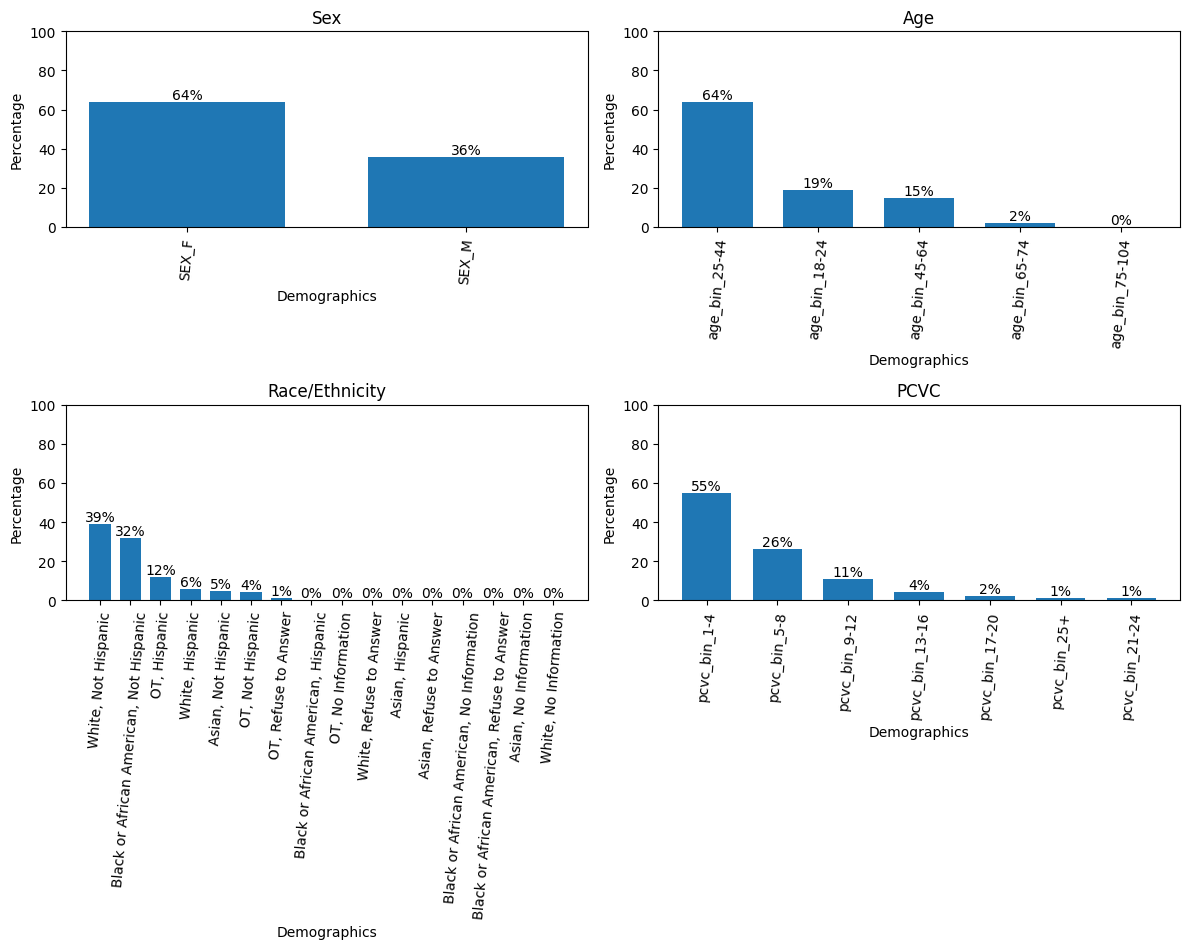

In [ ]:
# Percentages of features per cluster - top 10
intersection_clusters_16 = intersection_df['KModes_Cluster'].to_numpy()
intersection_df = intersection_df.rename(columns=lambda x: x.replace('race_ethnicity_', '') if x.startswith('race_ethnicity_') else x)

disease_prct_clusters = cluster_disease_percentage(intersection_clusters_16, intersection_df, 10, verbose=True)

clusters_demographics_prct = filter_cluster_by_demographics(disease_prct_clusters, dems)
plot_cluster_demographics_separately(clusters_demographics_prct, variable_subsets, subset_titles)

## OER Calculation (Intersection Dataset)

In [ ]:
diseases = ['Acute Myocardial Infarction', 'Alzheimer’s Disease', 'Anemia',
       'Asthma', 'Atrial Fibrillation and Flutter',
       'Benign Prostatic Hyperplasia', 'Cancer, Breast', 'Cancer, Colorectal',
       'Cancer, Endometrial', 'Cancer, Lung', 'Cancer, Prostate',
       'Cancer, Urologic', 'Cataract', 'Chronic Kidney Disease',
       'Chronic Obstructive Pulmonary Disease',
       'Depression, Bipolar, or Other Depressive Mood Disorders', 'Diabetes',
       'Glaucoma', 'Heart Failure and Non-Ischemic Heart Disease',
       'Hip/Pelvic Fracture', 'Hyperlipidemia', 'Hypertension',
       'Hypothyroidism', 'Ischemic Heart Disease', 'Non-Alzheimer’s Dementia',
       'Osteoporosis With or Without Pathological Fracture',
       'Parkinson’s Disease and Secondary Parkinsonism',
       'Pneumonia, All-cause', 'Rheumatoid Arthritis/Osteoarthritis',
       'Stroke/Transient Ischemic Attack']


In [ ]:
intersection_diseases_df = intersection_df[diseases]
disease_prevalence= calculate_disease_prevalence(intersection_diseases_df, intersection_clusters_16)

In [ ]:
pop_disease_prevalence = calculate_population_disease_prevalence(syndemics_data, syndemics_data.shape[0])
expected_coexistence = calculate_population_expected_coexistence(pop_disease_prevalence, debug_mode=False)
oer = calculate_oer(intersection_diseases_df, intersection_clusters_16, expected_coexistence, debug_mode=False)

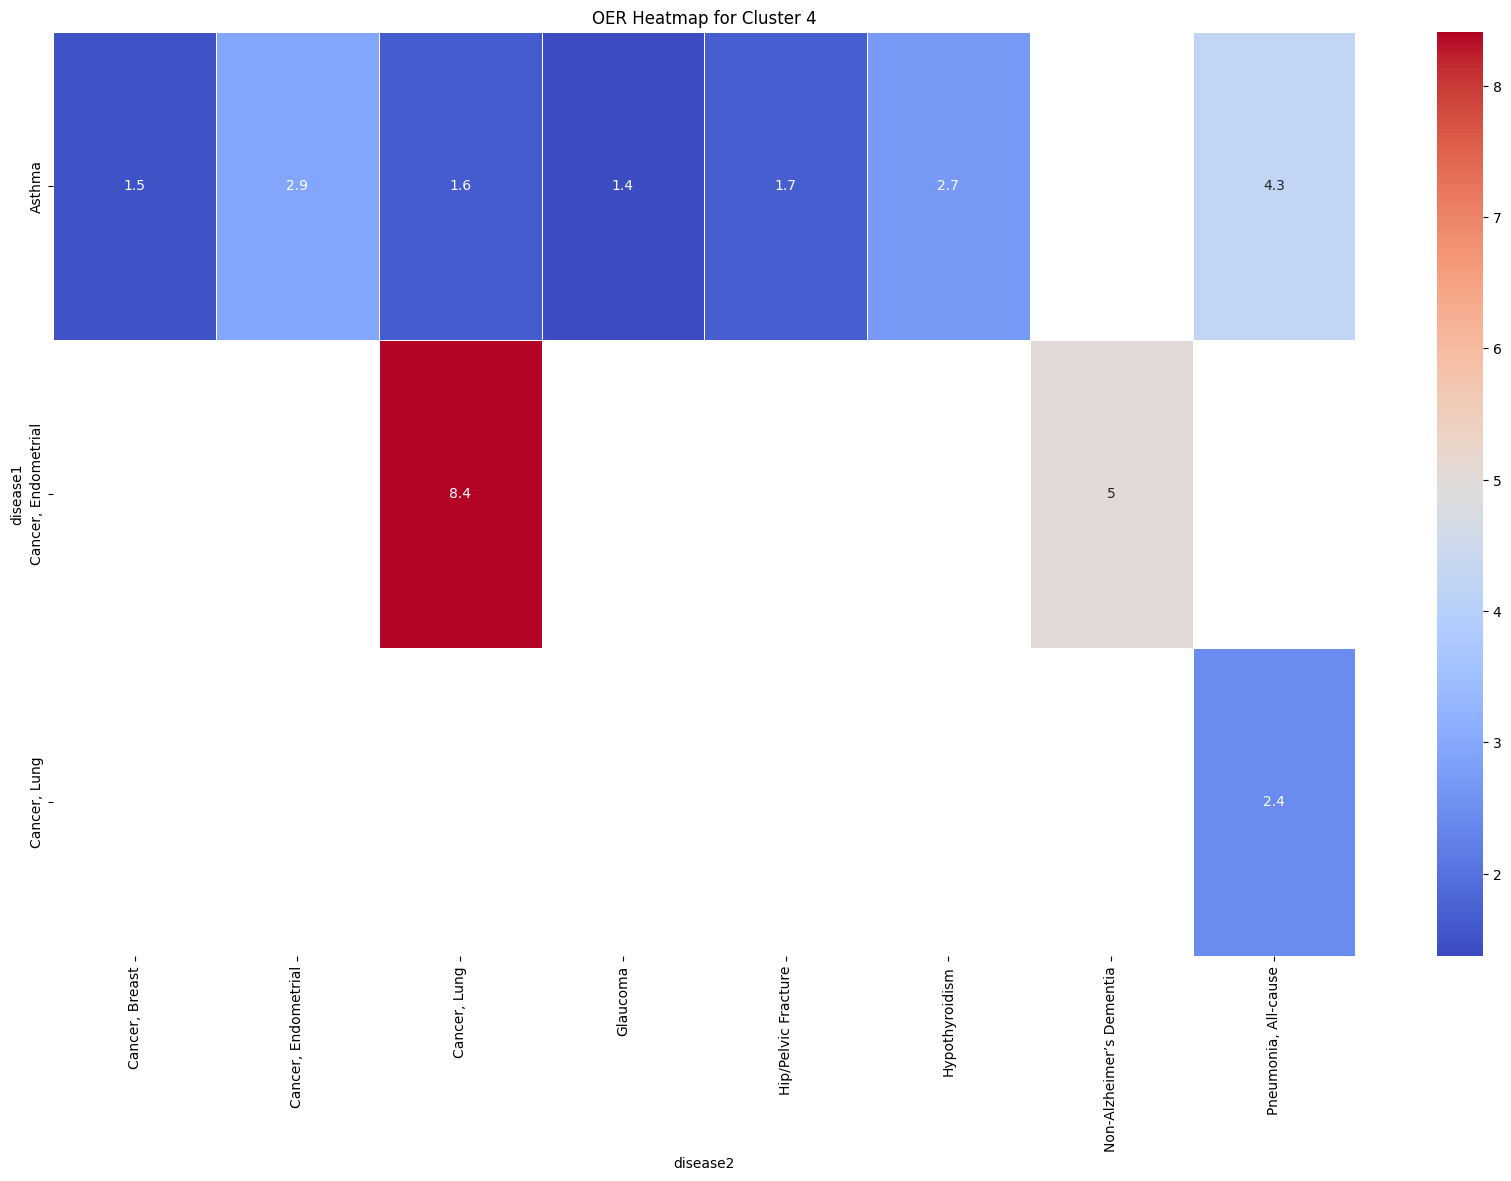

In [ ]:
plot_oer(oer,4)

Nodes kept in graph: ['Asthma', 'Cancer, Breast', 'Cancer, Endometrial', 'Cancer, Lung', 'Glaucoma', 'Hip/Pelvic Fracture', 'Hypothyroidism', 'Pneumonia, All-cause', 'Non-Alzheimer’s Dementia']


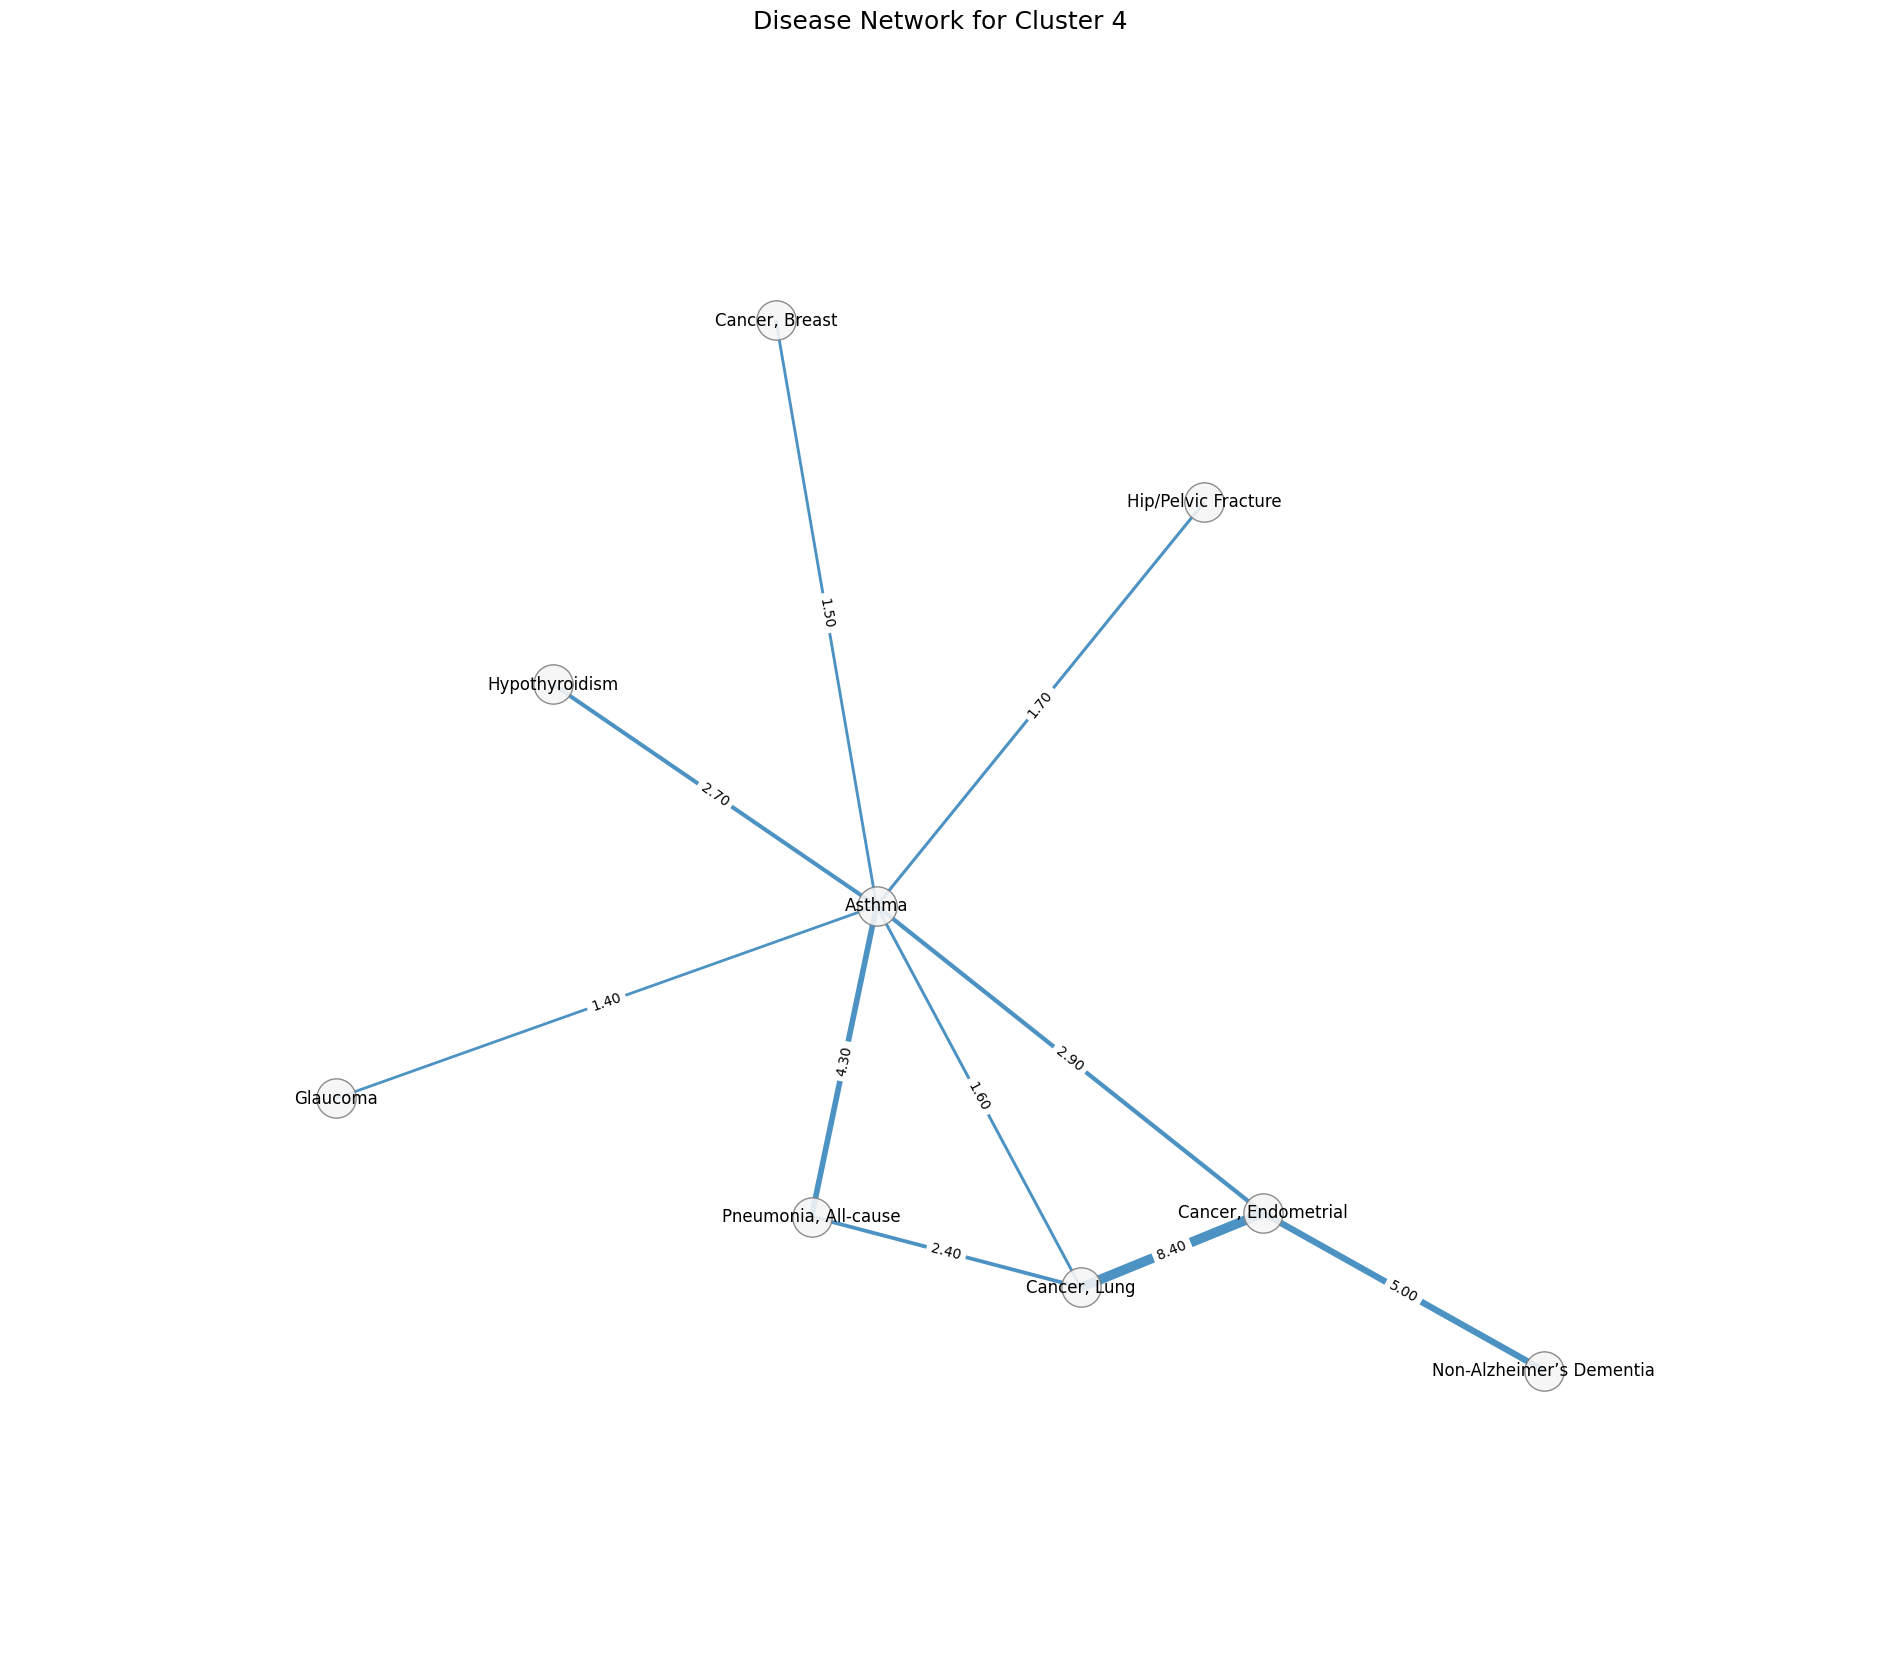

In [ ]:
clust_size = {4 : intersection_diseases_df.shape[0]}
plot_disease_graphs(oer, disease_prevalence, clust_size, prevalence_threshold=0.0)

## KModes : Disease graph

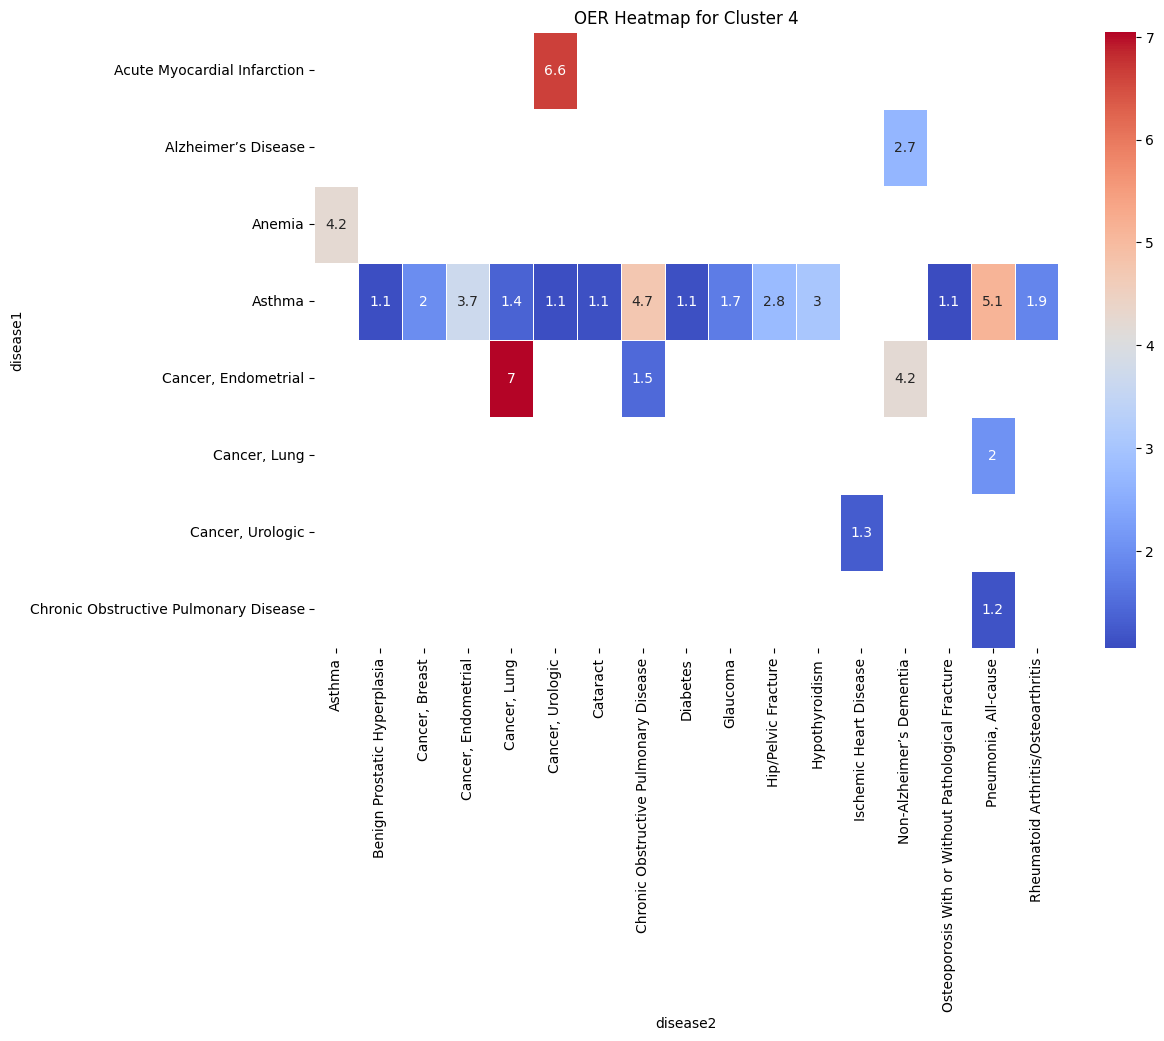

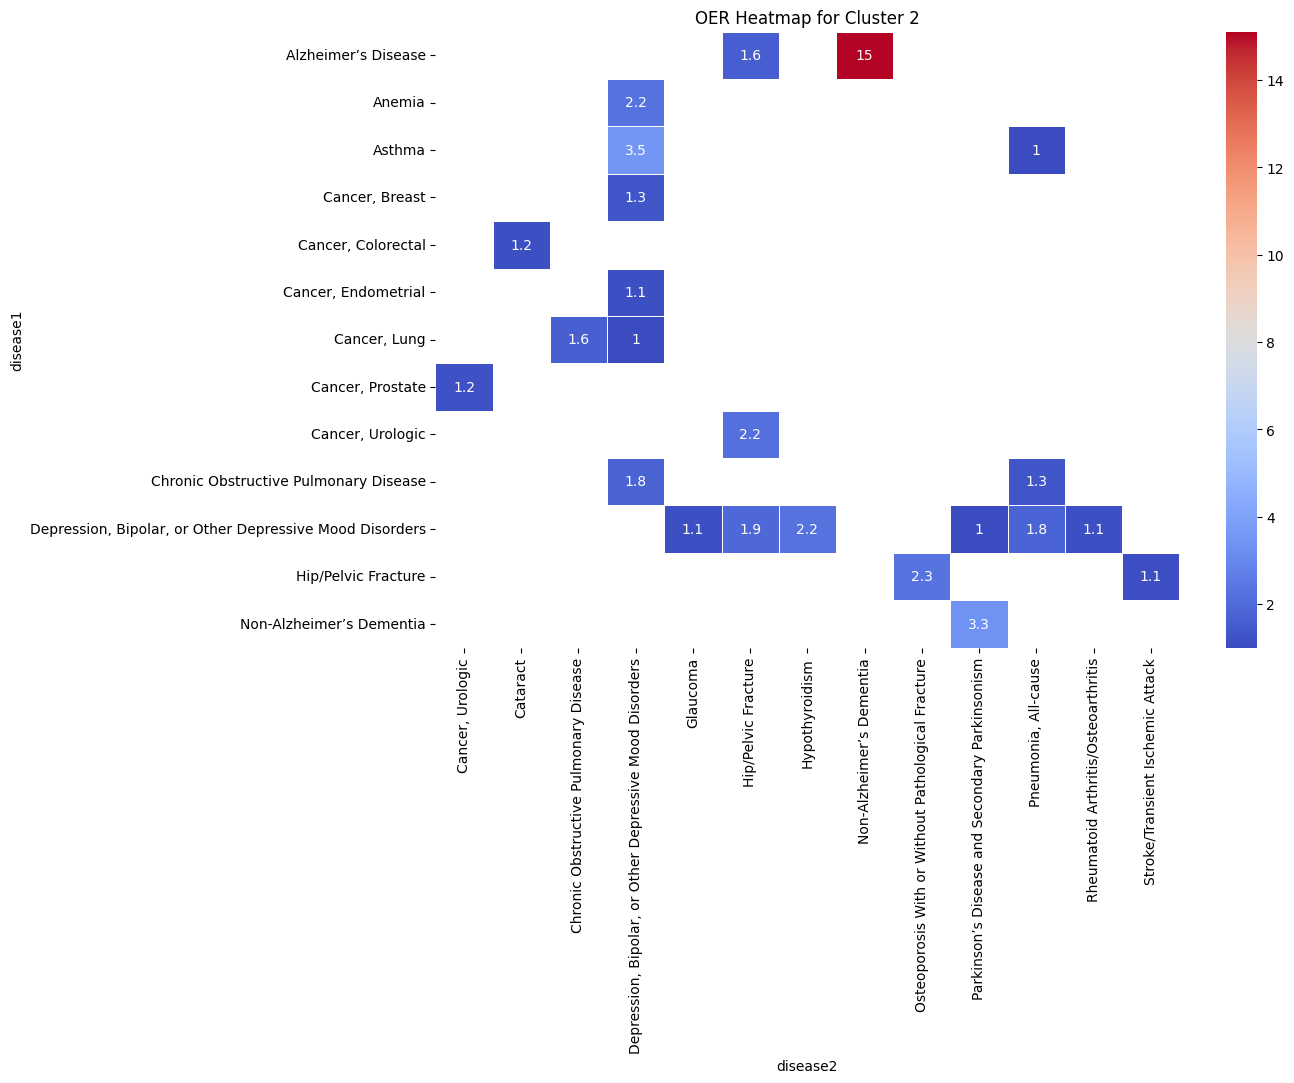

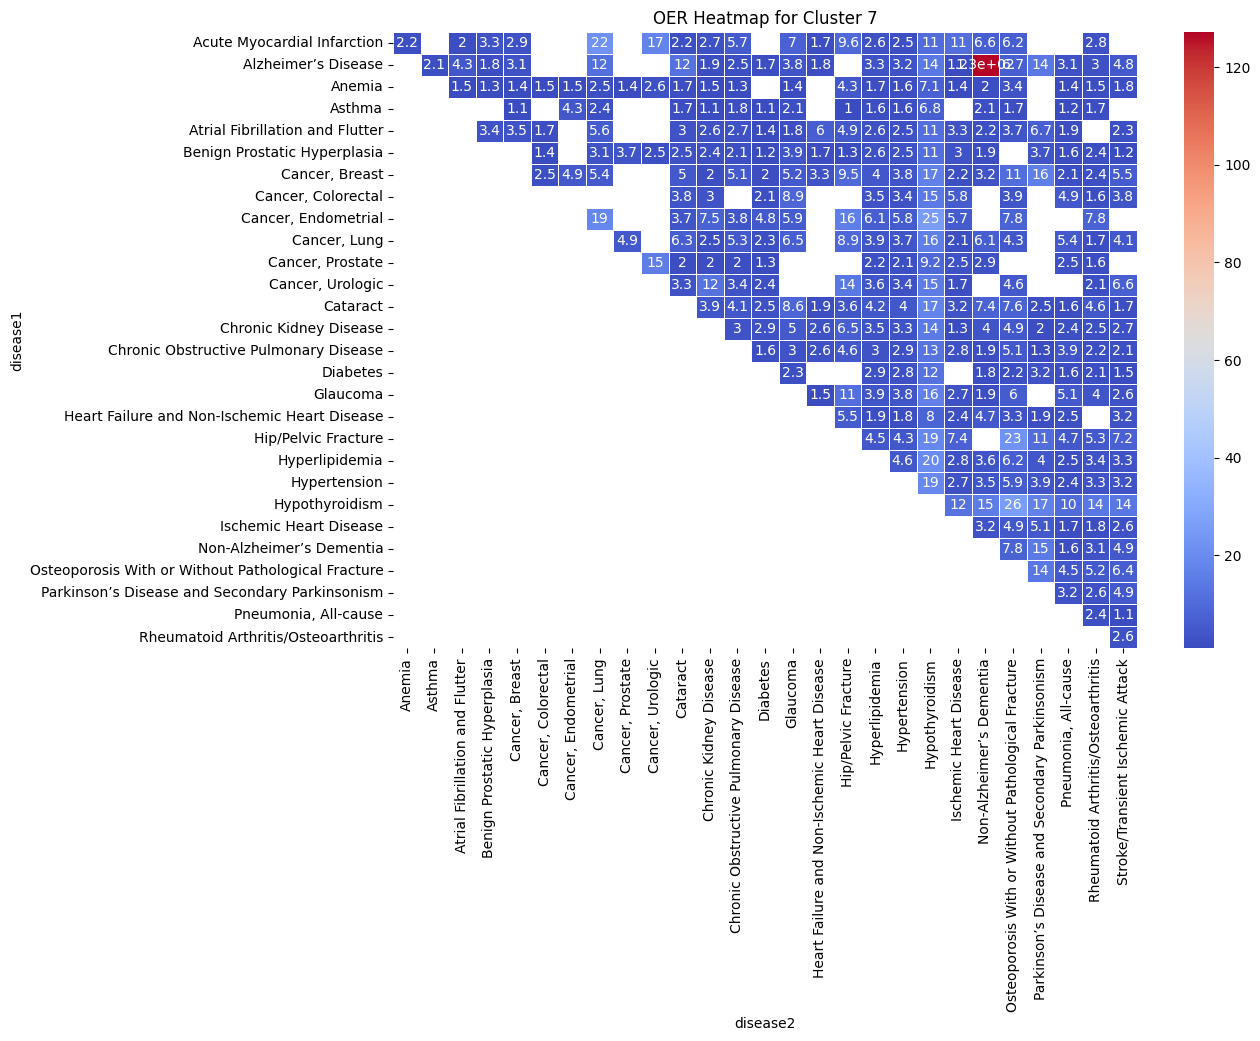

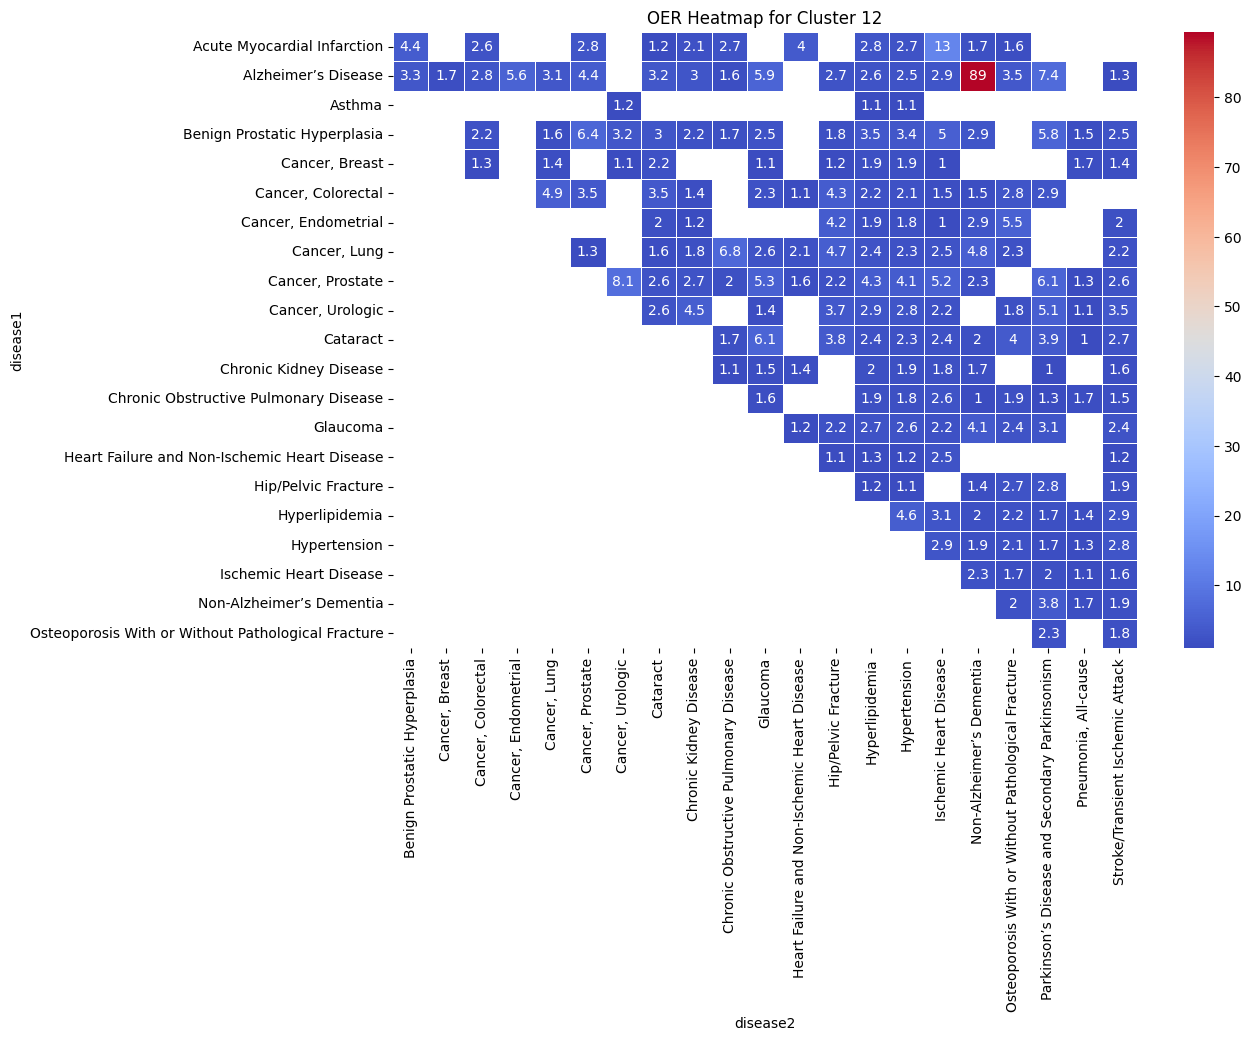

In [ ]:
syndemics_data = kmodes_clustered_df.drop('Cluster', axis = 1)
kmodes_clusters_16 = kmodes_clustered_df['Cluster'].to_numpy()

disease_prevalence_kmodes= calculate_disease_prevalence(syndemics_data, kmodes_clusters_16)

pop_disease_prevalence_kmodes = calculate_population_disease_prevalence(syndemics_data, syndemics_data.shape[0])

expected_coexistence_kmodes = calculate_population_expected_coexistence(pop_disease_prevalence_kmodes, debug_mode=False)

oer_16_kmodes = calculate_oer(syndemics_data, kmodes_clusters_16, expected_coexistence_kmodes, debug_mode=False)

plot_oer(oer_16_kmodes,4)

#plot_oer(oer_16_kmodes,2)

#plot_oer(oer_16_kmodes,7)

#plot_oer(oer_16_kmodes,12)


## Kmeans : Disease Graph

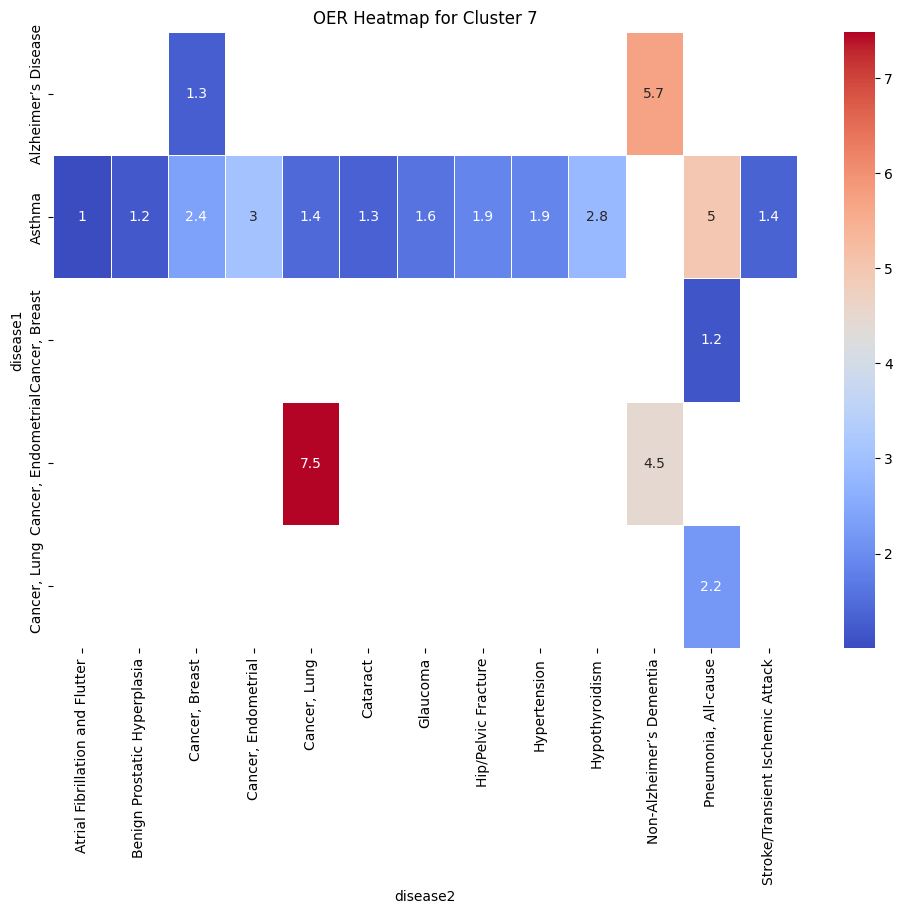

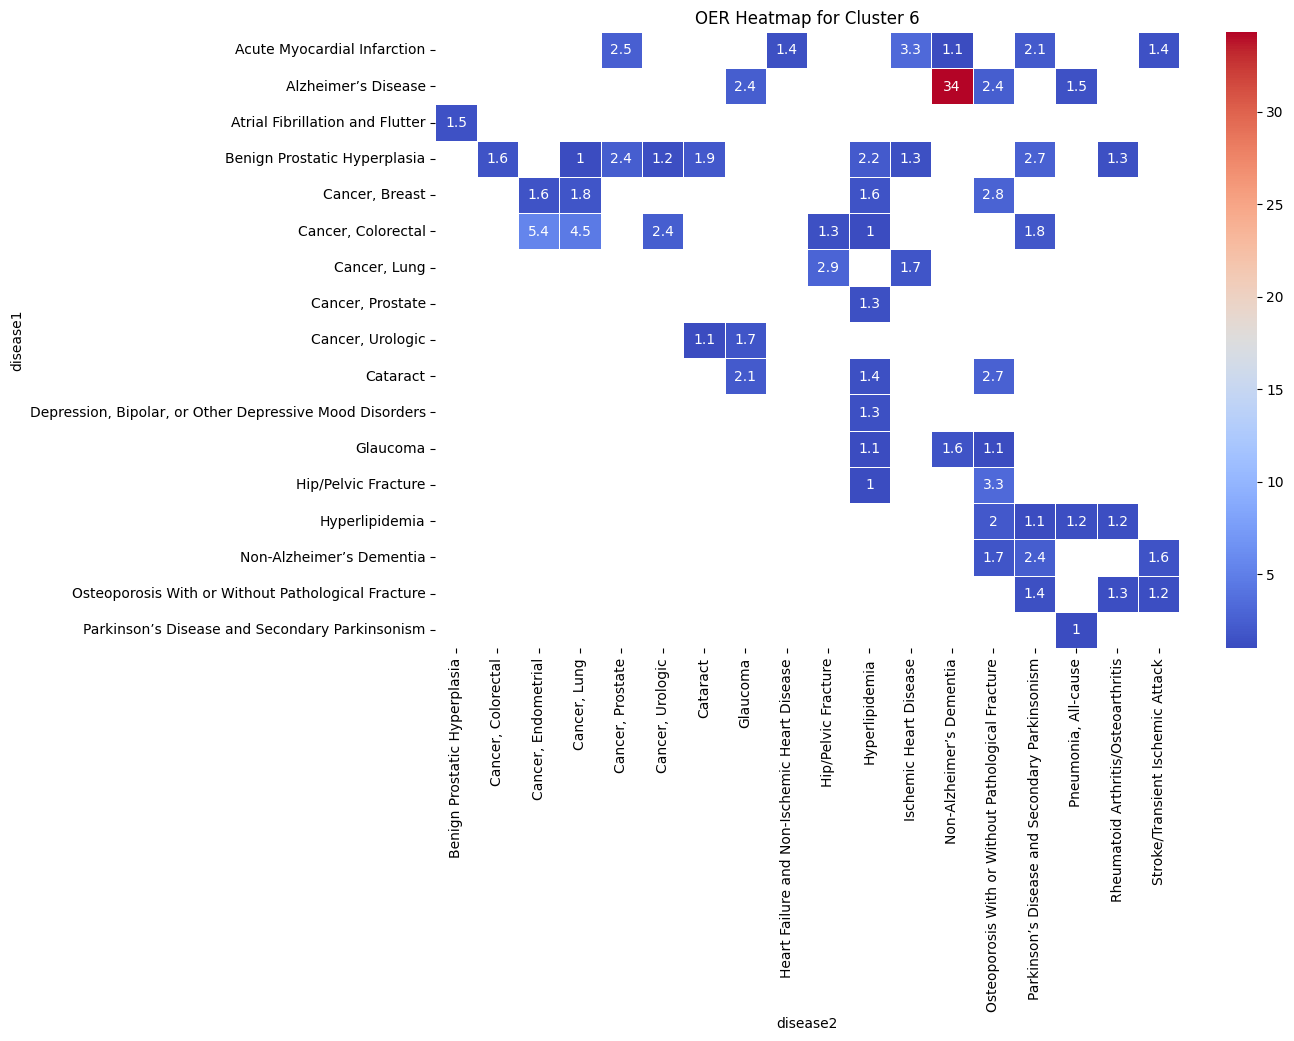

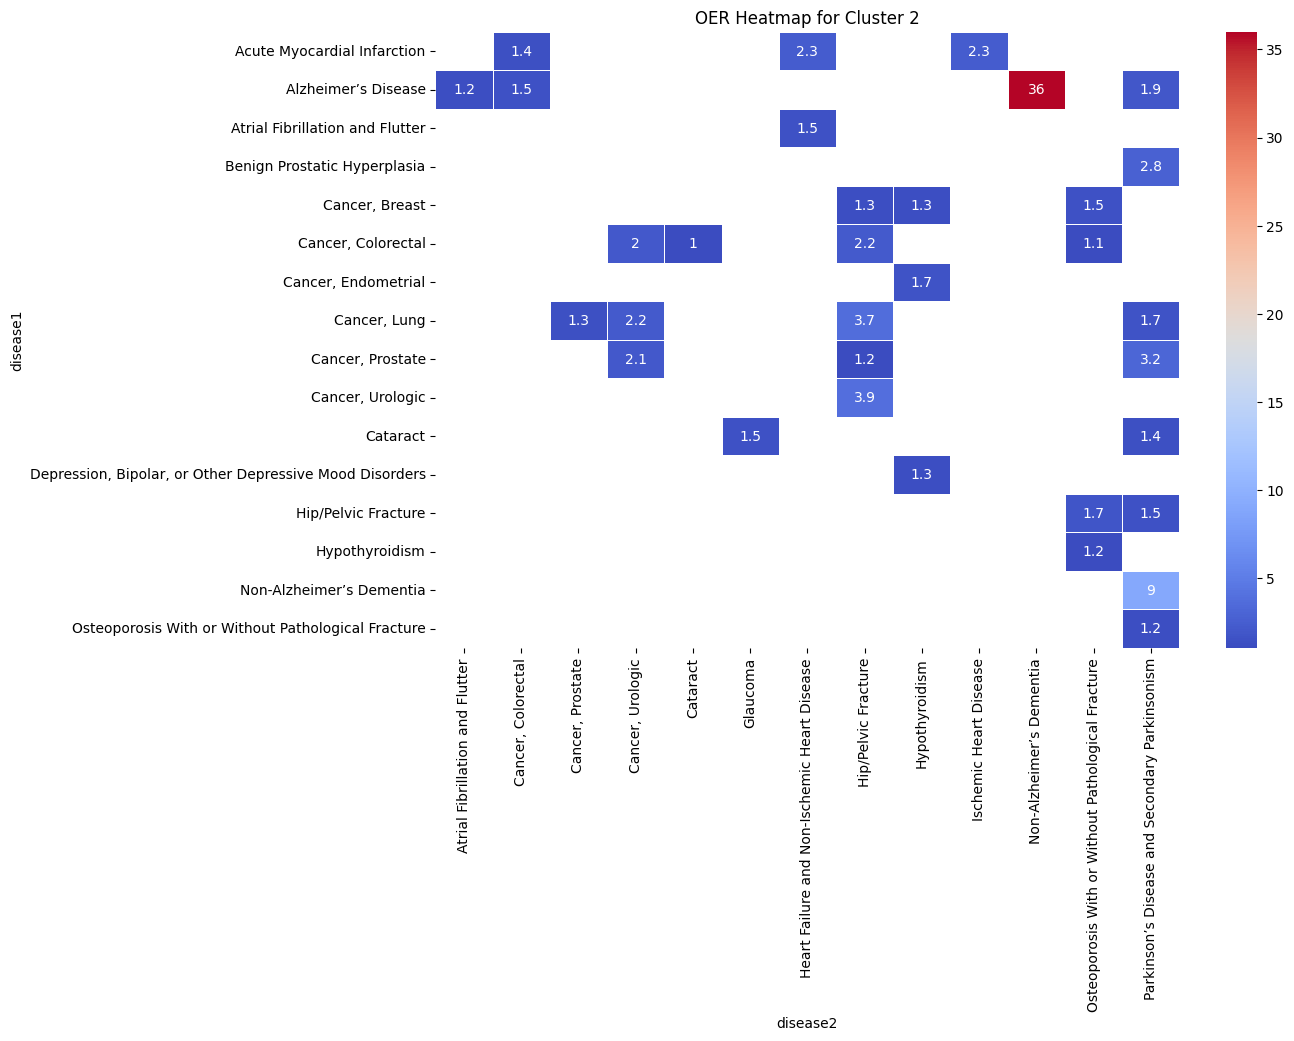

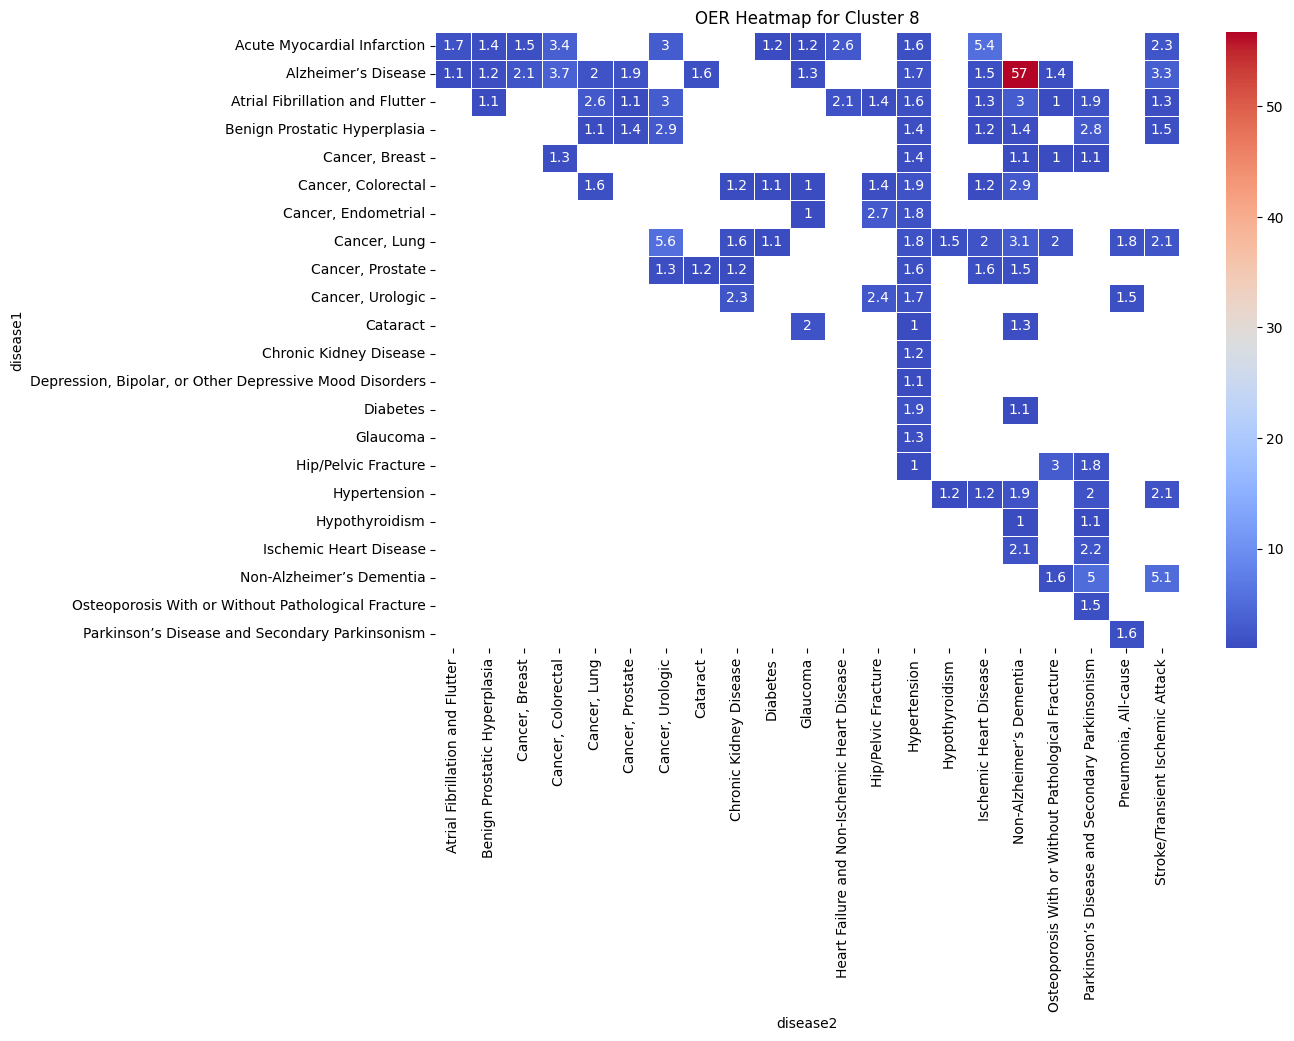

In [ ]:
syndemics_data = kmeans_clustered_df.drop('Cluster', axis = 1)
kmeans_clusters_16 = kmeans_clustered_df['Cluster'].to_numpy()

disease_prevalence_kmeans= calculate_disease_prevalence(syndemics_data, kmeans_clusters_16)
pop_disease_prevalence_kmeans = calculate_population_disease_prevalence(syndemics_data, syndemics_data.shape[0])
expected_coexistence_kmeans = calculate_population_expected_coexistence(pop_disease_prevalence_kmeans, debug_mode=False)
oer_16_kmeans = calculate_oer(syndemics_data, kmeans_clusters_16, expected_coexistence_kmeans, debug_mode=False)
plot_oer(oer_16_kmeans,7)
plot_oer(oer_16_kmeans,6)
plot_oer(oer_16_kmeans,2)
plot_oer(oer_16_kmeans,8)

In [ ]:
oer_16_kmeans[7]

,Acute Myocardial Infarction,Alzheimer’s Disease,Anemia,Asthma,Atrial Fibrillation and Flutter,Benign Prostatic Hyperplasia,"Cancer, Breast","Cancer, Colorectal","Cancer, Endometrial","Cancer, Lung","Cancer, Prostate","Cancer, Urologic",Cataract,Chronic Kidney Disease,Chronic Obstructive Pulmonary Disease,"Depression, Bipolar, or Other Depressive Mood Disorders",Diabetes,Glaucoma,Heart Failure and Non-Ischemic Heart Disease,Hip/Pelvic Fracture,Hyperlipidemia,Hypertension,Hypothyroidism,Ischemic Heart Disease,Non-Alzheimer’s Dementia,Osteoporosis With or Without Pathological Fracture,Parkinson’s Disease and Secondary Parkinsonism,"Pneumonia, All-cause",Rheumatoid Arthritis/Osteoarthritis,Stroke/Transient Ischemic Attack
Acute Myocardial Infarction,4.765509,0.000000,0.0,0.258460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.067003,0.000000,0.460048,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Alzheimer’s Disease,0.000000,16.580588,0.0,0.835024,0.869144,0.000000,1.268425,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.389403,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.144314,0.313661,0.000000,5.712393,0.000000,0.000000,0.000000,0.0,0.000000
Anemia,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Asthma,0.258460,0.835024,0.0,65.476741,1.006743,1.203445,2.363555,0.438304,3.039489,1.449523,0.800990,0.0,1.320638,0.451052,0.0,0.0,0.746559,1.605364,0.853094,1.888490,0.0,1.867847,2.843360,0.474068,0.719213,0.985405,0.287178,4.987806,0.0,1.360153
Atrial Fibrillation and Flutter,0.000000,0.869144,0.0,1.006743,3.143637,0.113874,0.398940,0.000000,0.000000,0.000000,0.357308,0.0,0.458200,0.183710,0.0,0.0,0.000000,0.477417,0.115820,0.000000,0.0,0.158862,0.000000,0.233734,0.449160,0.212207,0.000000,0.000000,0.0,0.303371
Benign Prostatic Hyperplasia,0.000000,0.000000,0.0,1.203445,0.113874,3.130844,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.254498,0.000000,0.0,0.0,0.046243,0.198879,0.000000,0.000000,0.0,0.103993,0.041096,0.000000,0.000000,0.000000,0.000000,0.164255,0.0,0.000000
"Cancer, Breast",0.000000,1.268425,0.0,2.363555,0.398940,0.000000,10.770911,0.000000,0.000000,0.000000,0.000000,0.0,0.445797,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.956222,0.0,0.264963,0.215957,0.113703,0.655502,0.464542,0.000000,1.150878,0.0,0.442738
"Cancer, Colorectal",0.000000,0.000000,0.0,0.438304,0.000000,0.000000,0.000000,6.852401,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.113626,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
"Cancer, Endometrial",0.000000,0.000000,0.0,3.039489,0.000000,0.000000,0.000000,0.000000,94.151209,7.483405,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.112565,0.000000,0.000000,4.455667,0.000000,0.000000,0.000000,0.0,0.000000
"Cancer, Lung",0.000000,0.000000,0.0,1.449523,0.000000,0.000000,0.000000,0.000000,7.483405,24.981692,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.153173,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.176252,0.0,0.000000
